# Test constructing graphs from the documents

For each node:
    Calculate the similarity between the node and all other nodes

For each node:
    Connect the node to the top N most similar nodes OR Connect the node to all nodes that are similar to it above a certain threshold

In [33]:
import sys
import os
import tqdm
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, AnyStr, List, Tuple, Any
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity

# Add the project root directory to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

# Import the modules using absolute imports
from src.etl import embedding_funcs, etl_funcs
from src.processing import v0_retrieval
from src.evaluation import output_funcs


In [2]:
# Load the document index
document_index = etl_funcs.load_documents()

# Embed the document index
embedded_index = embedding_funcs.embed_index(document_index)


Embedding Documents: 100%|██████████| 197/197 [00:04<00:00, 43.08it/s]


In [55]:
# Create an empty graph
graph = nx.Graph()

# Create a dictionary to store the connections
connections = {}

# Iterate over each document in the embedded_index with tqdm progress bar
for doc in tqdm.tqdm(embedded_index):
    
    # Retrieve the top k documents using v0_retrieval
    retrieved_docs = v0_retrieval.retrieve_top_k(np.array(doc.embedding), embedded_index, k=5)
    
    # Add the document as a node in the graph
    graph.add_node(doc.id_, **doc.metadata)
    
    # Add the connections to the dictionary
    connections[doc.id_] = [(retrieved_doc[0], retrieved_doc[1]) for retrieved_doc in retrieved_docs if retrieved_doc[0] != doc.id_]

# Add the connections to the graph
for node, connected_nodes in connections.items():
    graph.add_weighted_edges_from([(node, connected_node[0], connected_node[1][0][0]) for connected_node in connected_nodes if connected_node[1][0][0] > 0.5])

# Print the graph
print(graph)

100%|██████████| 197/197 [00:05<00:00, 35.30it/s]

Graph with 197 nodes and 562 edges


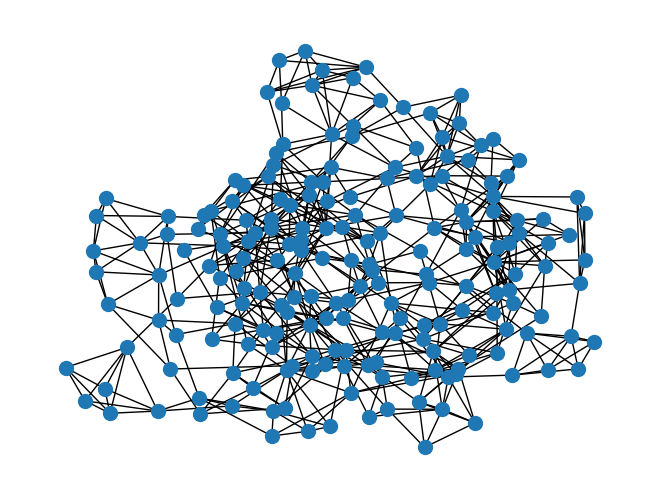

In [57]:
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100)


In [58]:
# Prune any edges with a weight below 0.6
pruned_graph = nx.Graph()

for edge in graph.edges(data=True):
    if edge[2]['weight'] > 0.5:
        pruned_graph.add_edge(edge[0], edge[1], weight=edge[2]['weight'])
        
# Print the pruned graph
print(pruned_graph)

Graph with 197 nodes and 562 edges


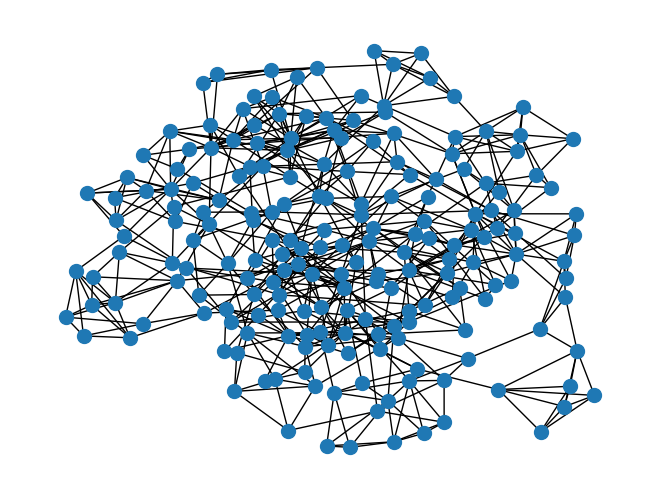

In [59]:
pos = nx.kamada_kawai_layout(pruned_graph)
nx.draw(pruned_graph, pos, node_size=100)

In [7]:
unique_docs = []
for doc in document_index:
    unique_docs.append(doc.metadata['file_name'])
    
set(unique_docs)

{'/Users/lukasalemu/Documents/00. Bank of England/00. Degree/Dissertation/structured-rag/data/01_raw/MPR November 2023.pdf',
 '/Users/lukasalemu/Documents/00. Bank of England/00. Degree/Dissertation/structured-rag/data/01_raw/monetary policy report february 2024.pdf'}

# Draw the graph but color the nodes based on which document they come from

In [8]:
# Draw the graph, but use the node_id to identify which of the two headline document elements is referenced within the node
colors = []
for n in pruned_graph.nodes:
    for doc in document_index:
        if doc.id_ == n:
            if doc.metadata['file_name'] == unique_docs[0]:
                colors.append('red')
            else:
                colors.append('blue')

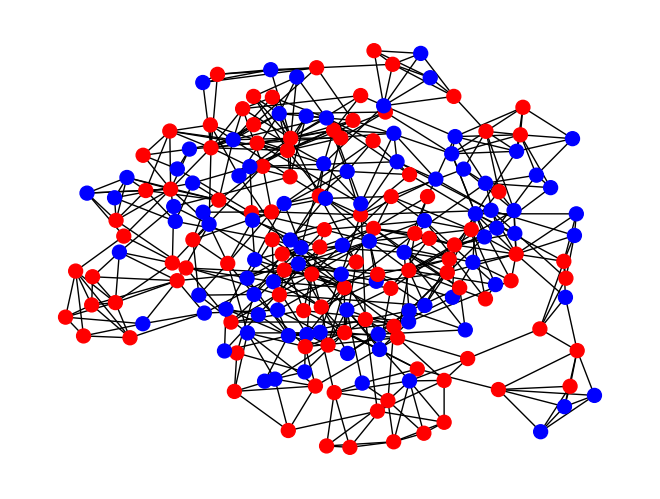

In [9]:
pos = nx.kamada_kawai_layout(pruned_graph)
nx.draw(pruned_graph, pos, node_size=100, node_color=colors)

# Takeaways:
- Need more documents in my test set to evaluate whether this will work as an evaluation method

# Evaluating the suitability of the graphs...
- No nodes are connected to themselves
- No nodes are isolated (i.e. all nodes are connected to at least one other node)
- The graph isn't overly dense (i.e. the number of edges is not too close to the number of possible edges)
- Anything else?

# Creating taxonomies using centrality metrics from the graph

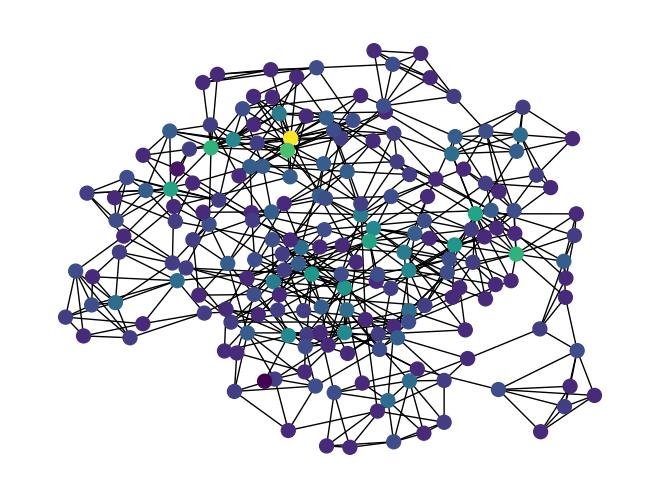

In [10]:
# Step 1: Compute centrality measures
centrality = nx.degree_centrality(pruned_graph)

# Color the nodes along a gradient of centrality
color_map = []
for node in pruned_graph.nodes:
    color_map.append(centrality[node])
    
# Step 2: Normalize the centrality values
min_centrality = min(color_map)
max_centrality = max(color_map)
color_map = [(centrality - min_centrality) / (max_centrality - min_centrality) for centrality in color_map]

# Step 3: Convert the color map to a list of RGB values using viridis colormap
cmap = mpl.colormaps['viridis']
color_map = [cmap(color) for color in color_map]

# Step 4: Draw the graph with the color map
pos = nx.kamada_kawai_layout(pruned_graph)
nx.draw(pruned_graph, pos, node_size=100, node_color=color_map)

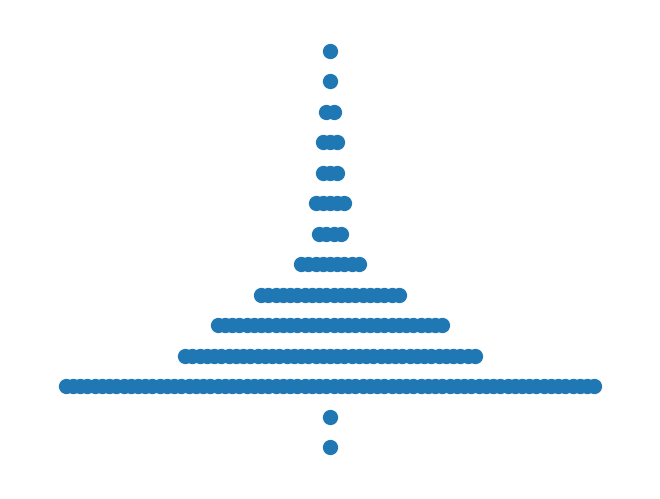

In [11]:
# Essentially a histogram of the centrality values
for node in pruned_graph.nodes:
    pruned_graph.nodes[node]['centrality'] = centrality[node]
    
pos = nx.multipartite_layout(pruned_graph, subset_key='centrality', align='horizontal')
nx.draw(pruned_graph, pos, node_size=100, edge_color='w')

# PUMP THE METADATA INTO THE NODES
Add all the document metadata into our graph nodes and make the edges weighted based on the connectivity.

In [12]:
for nd in tqdm.tqdm(list(pruned_graph.nodes)):
    for doc in document_index:
        if doc.id_ == nd:
            # Unpack the metadata dict into the node, on top of what is already there
            pruned_graph.nodes[nd].update(doc.metadata)

100%|██████████| 197/197 [00:00<00:00, 71638.45it/s]


In [13]:
list(pruned_graph.nodes(data=True))[0]



('a8a3f40f-5940-4632-977a-bc8ee274bade',
 {'centrality': 0.030612244897959183,
  'page_label': 'Cover',
  'file_name': '/Users/lukasalemu/Documents/00. Bank of England/00. Degree/Dissertation/structured-rag/data/01_raw/MPR November 2023.pdf',
  'Description': 'Our quarterly Monetary Policy Report sets out the economic analysis and inflation projections that the Monetary Policy Committee uses to make its interest rate decisions.',
  'Type': 'MPR',
  'Date': '2023-02-11 00:00:00',
  'Authors': 'Bank of England',
  'Topics': 'Inflation, GDP, Labour Market, Forecasts',
  'Brands': 'MPR',
  'Academic Research Cited?': 'No',
  'Divisions': 'Monetary Analysis',
  'MPC Round': 'Nov 2023',
  'Forecast Round': 'Nov 2023',
  'Tags': 'nan',
  'Related Notes': 'nan',
  'num_characters': '191572',
  'num_words': '30758',
  'most_common_words': "{'the': 1753, 'of': 1017, 'to': 935, 'in': 931, 'and': 651}",
  'links': "['https://www.bankofengland.co.uk/monetary-policy-report/2023/november-2023#chapter

# Evaluating Graphs:

How can I actually evaluate the graphs which I create using the retrieval algorithm? Can I not just directly evaluate the retrieval algorithm as well?

## Evaluation Metrics

#### Structural evaluation of the graph:
- Are all nodes in the graph connected to at least one other node?
- Are there no connections to oneself?
- Graph density - is it within a reasonable range? (to be determined)
- Is there a meaningful community structure which aligns itself around economic topics such as inflation, unemployment, etc.?
- Are the most central nodes in the graph related to documents which I'd expect to be central (e.g. MPRs).

I can do this first and it will work to some extent, to evaluate as a second-order features of the graph which the different algorithms create. But it will not evaluate the retrieval algorithm itself.

#### Evaluation of the retrieval algorithm
To do so - there's no getting away from it - I need to develop a way to evaluate the retrieval algorithm. This means:
1. Collecting a set of test documents
2. Generate queries which are expected to be significant for my target audience
3. Judge the relevance of document chunks to each query.

I can employ semi-automated techniques to make the final step simpler. These include:
- Use existing algorithms to initially rank the documents, perhaps into a top 10.
- Build a tool to query users as to the relevance of the document chunk - query pairs, making the process simpler.

# Starting out: Structural graph evaluation

We can assess the link between our graph quality evaluation and our retrieval algorithm evaluation. Hopefully, independent evaluation of both from first principles lands us in the same place in terms of the best algorithm and tuning parameters for our retrieval algorithm.

1. Degree assortativity
    - Are the most connected nodes connected to other highly connected nodes?
    - Are highly influential documents super connected to other highly influential documents? Intuitition is no due to the MECE nature of the work.
2. Attribute assortativity
    - Are nodes from the same document connected to each other? - YES
    - Are documents from the same year connected to each other? - SOMEWHAT
    - Are documents from the same author connected to each other? - SOMEWHAT
    - And other attributes - what do we expec tthe link to be?
3. Average connectivity of the graph:
    - Are sub-graphs of the graph strongly or weakly linked?
    - Intuitively, I'd want the graph to have a pretty low connectivity, as if the heirarchy is effective, then groupings should be related via a few key nodes / documents.
4. Clique detection: - ACTUALLY NOT USEFUL
    - Are there any cliques in the graph?
    - Are these cliques meaningful?
    - How do the cliques change as we change the algorithm?
5. Community detection:
    - How many distinct communities can we detect in the graph?
    - Are these communities meaningful? How can we summarise their meaning (summarise embeddgin of the nodes in the community).
    - As we change the algorithm, how do the communities change?
        - Can we use Girvan-Newman to detect communities?
6. Node classification:
    - Can we predict the document from which the nodes come from as a result of the graph structure and embedded metadata?
        - Intuitively, for similar documents, we won't be able to.
    - Can we predict year or other categorical data?
7. Similarity of graphs:
    - How can we quantitatively assess the similarity of graphs built using different algorithms?
8. Small-world detection:
    - Can we detect small-world properties in the graph?
    - How do these properties change as we change the algorithm?
    - Inuitively - do we want our graph to have small-world properties? I think yes, so lets test for these properties.



Other factors to consider:
- What if we made the graphs directed based on the date of the documents being considered?

### Assortativity

In [14]:
# Degree assortativity
# Starting out with this metric.

# Question 1: What is the degree assortativity of the graph?
deg_assort = nx.degree_assortativity_coefficient(pruned_graph)
deg_assort
# This is super low. This is actually to be expected given we have one document, but let's see how sensitive it is to the threshold value.

0.004376782266041703

In [15]:
# Attribute assortativity based on the edge weighting
source_assort = nx.attribute_assortativity_coefficient(pruned_graph, 'file_name')
source_assort

# Interesting that it's so low - but that's because we basically have two of the same document here.

0.04014279843846328

In [16]:
# I would expect this to be much closer, given the MPR has a similar structure usually?
page_assort = nx.attribute_assortativity_coefficient(pruned_graph, 'page_label')
page_assort

# Turns out not - I suppose that most pages are dependent on the length of sections so won't be consistent.
# Might be interest to see how this looks with a quantitative difference...

0.0016052546081050155

In [17]:
# Centrality - expect this to have a low assortativity. This probably means we don't really have hubs in the graph (not that small-worldy).
cent_assort = nx.numeric_assortativity_coefficient(pruned_graph, 'centrality')
cent_assort

0.004376782266041763

In [18]:
# Date - for our MPR set expect this to be the same as the source assortativity
date_assort = nx.attribute_assortativity_coefficient(pruned_graph, 'Date')
date_assort

0.04014279843846328

In [19]:
# Convert the date attribute to a numeric value
for node in pruned_graph.nodes:
    pruned_graph.nodes[node]['Date_num'] = int(pd.Timestamp(pruned_graph.nodes[node]['Date']).timestamp())
    
date_dist_assort = nx.numeric_assortativity_coefficient(pruned_graph, 'Date_num')
date_dist_assort

0.04014279843848181

Seems our graph, in this test set has a pretty low assortativity in general. This is expected.

### Average Connectivity

What is connectivity representing here?

In [20]:
avg_conn = nx.average_node_connectivity(pruned_graph)
avg_conn

# This is super sensitive to the threshold I apply on both the k and the edge weight.
# This is pretty high, though we've currently got some bad documents for testing / tuning this.

4.21972443799855

In [21]:
edge_conn = nx.edge_connectivity(pruned_graph)
edge_conn

# The edge connectivity is equal to the minimum number of edges that must be removed to disconnect G or render it trivial.
# This being so low is a bit of a surprise.

2

In [22]:
node_conn = nx.node_connectivity(pruned_graph)
node_conn

# Node connectivity is equal to the minimum number of nodes that must be removed to disconnect G or render it trivial.

2

Connectivity will be interesting only when we're operating on more data

### Community Detection



In [23]:
communities_asyn = list(nx.community.asyn_lpa_communities(pruned_graph, weight='weight'))
communities_asyn = [frozenset(community) for community in communities_asyn] # Convert to frozensets to allow hashing later

communities_greedy = list(nx.community.greedy_modularity_communities(pruned_graph, weight='weight'))

communities_fluid = list(nx.community.asyn_fluidc(pruned_graph, k=5))
communities_fluid = [frozenset(community) for community in communities_fluid] # Convert to frozensets to allow hashing later


The modularity of this method is: 0.6415820299409496


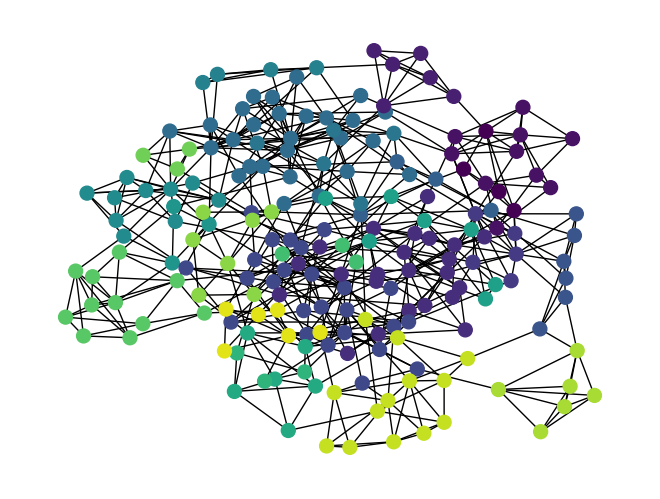

In [24]:
# Split viridis into n colors
n = len(communities_asyn)
viridis = mpl.colormaps['viridis']
colors = [viridis(i/n) for i in range(n)]

# Create a dictionary that maps each community to a color
community_color_dict = {community: color for community, color in zip(communities_asyn, colors)}

node_colors = []

for node in pruned_graph.nodes:
    # Find which community the node belongs to
    for community, color in community_color_dict.items():
        if node in community:
            node_colors.append(color)

# Draw the graph with the communities colored
pos = nx.kamada_kawai_layout(pruned_graph)
nx.draw(pruned_graph, pos, node_size=100, node_color=node_colors)

# Print the modularity of the partition
modularity = nx.community.modularity(pruned_graph, communities_asyn)
print("The modularity of this method is:",modularity)

The modularity of this method is: 0.6835794726044356


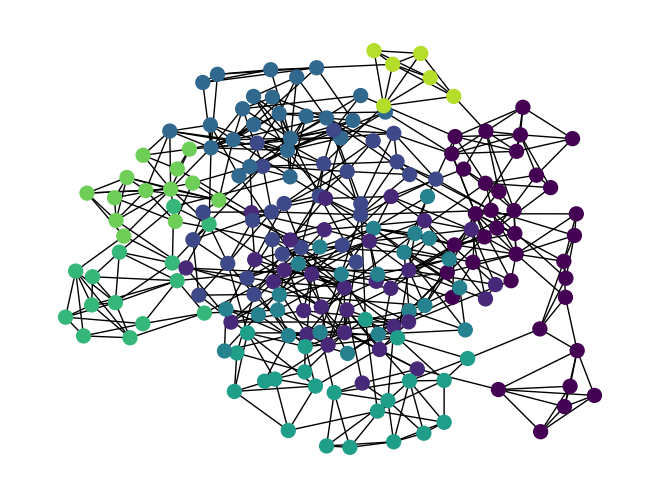

In [25]:
# Split viridis into n colors
n = len(communities_greedy)
viridis = mpl.colormaps['viridis']
colors = [viridis(i/n) for i in range(n)]

# Create a dictionary that maps each community to a color
community_color_dict = {community: color for community, color in zip(communities_greedy, colors)}

node_colors = []

for node in pruned_graph.nodes:
    # Find which community the node belongs to
    for community, color in community_color_dict.items():
        if node in community:
            node_colors.append(color)

# Draw the graph with the communities colored
pos = nx.kamada_kawai_layout(pruned_graph)
nx.draw(pruned_graph, pos, node_size=100, node_color=node_colors)

# Print the modularity of the partition
modularity = nx.community.modularity(pruned_graph, communities_greedy)
print("The modularity of this method is:",modularity)

The modularity of this method is: 0.6018302857018747


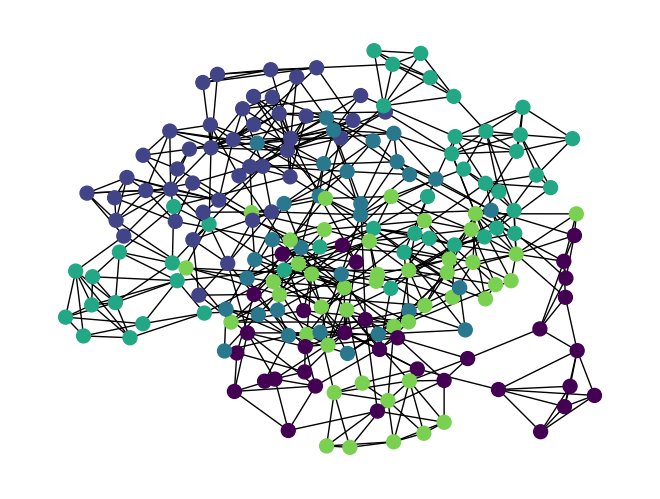

In [26]:
# Split viridis into n colors
n = len(communities_fluid)
viridis = mpl.colormaps['viridis']
colors = [viridis(i/n) for i in range(n)]

# Create a dictionary that maps each community to a color
community_color_dict = {community: color for community, color in zip(communities_fluid, colors)}

node_colors = []

for node in pruned_graph.nodes:
    # Find which community the node belongs to
    for community, color in community_color_dict.items():
        if node in community:
            node_colors.append(color)

# Draw the graph with the communities colored
pos = nx.kamada_kawai_layout(pruned_graph)
nx.draw(pruned_graph, pos, node_size=100, node_color=node_colors)

# Print the modularity of the partition
modularity = nx.community.modularity(pruned_graph, communities_fluid)
print("The modularity of this method is:",modularity)

The greedy communities perform the best - how can we evaluate their qualities?

Let's use the evaluation we did before

In [27]:
# Create the subgraph
greedy_graphs = []

for comm in communities_greedy:
    subgraph = pruned_graph.subgraph(comm)
    greedy_graphs.append(subgraph)

In [28]:
for ggraph in greedy_graphs:
    # Print our the evaluation we did on attribute assortativity and the like
    print("Degree assortativity:", nx.degree_assortativity_coefficient(ggraph))
    print("Attribute assortativity file name", nx.attribute_assortativity_coefficient(ggraph, 'file_name'))
    print("Attribute assortativity page label", nx.attribute_assortativity_coefficient(ggraph, 'page_label'))
    print("Numeric assortativity centrality", nx.numeric_assortativity_coefficient(ggraph, 'centrality'))
    print("Attribute assortativity date", nx.attribute_assortativity_coefficient(ggraph, 'Date'))
    print("Numeric assortativity date", nx.numeric_assortativity_coefficient(ggraph, 'Date_num'))
    print("Average node connectivity ", nx.average_node_connectivity(ggraph))
    print("Edge connectivity", nx.edge_connectivity(ggraph))
    print("Node connectivity ", nx.node_connectivity(ggraph))
    print("Size of the graph", len(ggraph))
    print("-----------------")
    

Degree assortativity: -0.16132507406409982
Attribute assortativity file name -0.06526315789473704
Attribute assortativity page label 0.008484354849657245
Numeric assortativity centrality -0.0603761555626404
Attribute assortativity date -0.06526315789473704
Numeric assortativity date -0.0652631578987476
Average node connectivity  2.3380952380952382
Edge connectivity 2
Node connectivity  1
Size of the graph 36
-----------------
Degree assortativity: 0.003855297821756477
Attribute assortativity file name -0.10119047619047618
Attribute assortativity page label -0.032591035075982044
Numeric assortativity centrality -0.015465566428819206
Attribute assortativity date -0.10119047619047618
Numeric assortativity date -0.10119047619013226
Average node connectivity  3.318279569892473
Edge connectivity 2
Node connectivity  2
Size of the graph 31
-----------------
Degree assortativity: -0.006934125804853272
Attribute assortativity file name -0.12592592592592608
Attribute assortativity page label -0.

Can we compare the topics of the documents in the individual communities? Are they similar in some way?


In [29]:
community_embeddings = []
for ggraph in greedy_graphs:
    ggraph_embed = []
    # print(ggraph.nodes(data=True))
    for node in ggraph.nodes:
        for doc in document_index:
            if doc.id_ == node:
                ggraph_embed.append(doc.embedding)
    
    # Evaluate how similar the embeddings within a single community are
    ggraph_embed = np.array(ggraph_embed)

    # Compute the similarity
    similarity_matrix = cosine_similarity(ggraph_embed)
    print("Similarity of node embeddings is: ", np.mean(similarity_matrix))
    
    # Compute and print the standard deviation
    std_dev = np.std(similarity_matrix)
    print("Standard deviation of node embeddings is: ", std_dev)
    print("-----------------")

# Global similarity of the embeddings for comparison
global_embeddings = []

for node in pruned_graph.nodes:
    for doc in document_index:
        if doc.id_ == node:
            global_embeddings.append(doc.embedding)

global_embeddings = np.array(global_embeddings)

# Compute the similarity
similarity_matrix = cosine_similarity(global_embeddings)
print("GLOBAL Similarity of node embeddings is: ", np.mean(similarity_matrix))

# Compute and print the standard deviation
std_dev = np.std(similarity_matrix)
print("GLOBAL Standard deviation of node embeddings is: ", std_dev)


Similarity of node embeddings is:  0.5432336837782411
Standard deviation of node embeddings is:  0.16834390620650672
-----------------
Similarity of node embeddings is:  0.6064563126684991
Standard deviation of node embeddings is:  0.13195082453439355
-----------------
Similarity of node embeddings is:  0.5903252367293303
Standard deviation of node embeddings is:  0.13895716927745694
-----------------
Similarity of node embeddings is:  0.6899457747871416
Standard deviation of node embeddings is:  0.10734543972508469
-----------------
Similarity of node embeddings is:  0.569512603623799
Standard deviation of node embeddings is:  0.15286350740779425
-----------------
Similarity of node embeddings is:  0.5479150652374549
Standard deviation of node embeddings is:  0.19030122765505328
-----------------
Similarity of node embeddings is:  0.6703828444004756
Standard deviation of node embeddings is:  0.128416033347817
-----------------
Similarity of node embeddings is:  0.5733365361094093
Stan

Next step would be to try to understand the semantic meaning of the communities. Either using an LLM, the metadata, or some kind of topic modelling.

Am skipping this out for now, given the time constraints.

### Node Classification

In [54]:
def node_classification(graph: nx.Graph, label_to_predict: AnyStr = 'file_name') -> Dict[AnyStr, Any]:
    """
    How effectively can we classify the nodes using their structure in the graph?
    We can try this across any number of our attributes for each node.
    """
    
    stats = {}
    
    node_class_preds_lclglbl = nx.algorithms.node_classification.local_and_global_consistency(graph, label_name=label_to_predict)
    node_class_preds_harmonic = nx.algorithms.node_classification.harmonic_function(graph, label_name=label_to_predict)
    
    node_class_true = [graph.nodes[node][label_to_predict] for node in graph.nodes]

    # Evaluate the predictions
    stats['precision_lclglbl'] = precision_score(node_class_true, node_class_preds_lclglbl, average='weighted')
    stats['recall_lclglbl'] = recall_score(node_class_true, node_class_preds_lclglbl, average='weighted')
    stats['f1_lclglbl'] = f1_score(node_class_true, node_class_preds_lclglbl, average='weighted')
    
    stats['precision_harmonic'] = precision_score(node_class_true, node_class_preds_harmonic, average='weighted')
    stats['recall_harmonic'] = recall_score(node_class_true, node_class_preds_harmonic, average='weighted')
    stats['f1_harmonic'] = f1_score(node_class_true, node_class_preds_harmonic, average='weighted')

    return stats

test1 = node_classification(pruned_graph, label_to_predict='file_name')
test1

{'precision_lclglbl': 0.7904937701892016,
 'recall_lclglbl': 0.7258883248730964,
 'f1_lclglbl': 0.7030144367982112,
 'precision_harmonic': 1.0,
 'recall_harmonic': 1.0,
 'f1_harmonic': 1.0}

In [46]:
# Custom classification algorithm:
import numpy as np
import scipy as sp

def to_scipy_sparse_array(G, nodelist=None, dtype=None, weight="weight", format="csr"):
    """Returns the graph adjacency matrix as a SciPy sparse array.

    Parameters
    ----------
    G : graph
        The NetworkX graph used to construct the sparse matrix.

    nodelist : list, optional
       The rows and columns are ordered according to the nodes in `nodelist`.
       If `nodelist` is None, then the ordering is produced by G.nodes().

    dtype : NumPy data-type, optional
        A valid NumPy dtype used to initialize the array. If None, then the
        NumPy default is used.

    weight : string or None   optional (default='weight')
        The edge attribute that holds the numerical value used for
        the edge weight.  If None then all edge weights are 1.

    format : str in {'bsr', 'csr', 'csc', 'coo', 'lil', 'dia', 'dok'}
        The type of the matrix to be returned (default 'csr').  For
        some algorithms different implementations of sparse matrices
        can perform better.  See [1]_ for details.

    Returns
    -------
    A : SciPy sparse array
       Graph adjacency matrix.

    Notes
    -----
    For directed graphs, matrix entry i,j corresponds to an edge from i to j.

    The matrix entries are populated using the edge attribute held in
    parameter weight. When an edge does not have that attribute, the
    value of the entry is 1.

    For multiple edges the matrix values are the sums of the edge weights.

    When `nodelist` does not contain every node in `G`, the adjacency matrix
    is built from the subgraph of `G` that is induced by the nodes in
    `nodelist`.

    The convention used for self-loop edges in graphs is to assign the
    diagonal matrix entry value to the weight attribute of the edge
    (or the number 1 if the edge has no weight attribute).  If the
    alternate convention of doubling the edge weight is desired the
    resulting SciPy sparse array can be modified as follows:

    >>> G = nx.Graph([(1, 1)])
    >>> A = nx.to_scipy_sparse_array(G)
    >>> print(A.todense())
    [[1]]
    >>> A.setdiag(A.diagonal() * 2)
    >>> print(A.toarray())
    [[2]]

    Examples
    --------
    >>> G = nx.MultiDiGraph()
    >>> G.add_edge(0, 1, weight=2)
    0
    >>> G.add_edge(1, 0)
    0
    >>> G.add_edge(2, 2, weight=3)
    0
    >>> G.add_edge(2, 2)
    1
    >>> S = nx.to_scipy_sparse_array(G, nodelist=[0, 1, 2])
    >>> print(S.toarray())
    [[0 2 0]
     [1 0 0]
     [0 0 4]]

    References
    ----------
    .. [1] Scipy Dev. References, "Sparse Matrices",
       https://docs.scipy.org/doc/scipy/reference/sparse.html
    """
    import scipy as sp

    if len(G) == 0:
        raise nx.NetworkXError("Graph has no nodes or edges")

    if nodelist is None:
        nodelist = list(G)
        nlen = len(G)
    else:
        nlen = len(nodelist)
        if nlen == 0:
            raise nx.NetworkXError("nodelist has no nodes")
        nodeset = set(G.nbunch_iter(nodelist))
        if nlen != len(nodeset):
            for n in nodelist:
                if n not in G:
                    raise nx.NetworkXError(f"Node {n} in nodelist is not in G")
            raise nx.NetworkXError("nodelist contains duplicates.")
        if nlen < len(G):
            G = G.subgraph(nodelist)

    index = dict(zip(nodelist, range(nlen)))
    coefficients = zip(
        *((index[u], index[v], wt) for u, v, wt in G.edges(data=weight, default=1))
    )
    try:
        row, col, data = coefficients
    except ValueError:
        # there is no edge in the subgraph
        row, col, data = [], [], []

    if G.is_directed():
        A = sp.sparse.coo_array((data, (row, col)), shape=(nlen, nlen), dtype=dtype)
    else:
        # symmetrize matrix
        d = data + data
        r = row + col
        c = col + row
        # selfloop entries get double counted when symmetrizing
        # so we subtract the data on the diagonal
        selfloops = list(nx.selfloop_edges(G, data=weight, default=1))
        if selfloops:
            diag_index, diag_data = zip(*((index[u], -wt) for u, v, wt in selfloops))
            d += diag_data
            r += diag_index
            c += diag_index
        A = sp.sparse.coo_array((d, (r, c)), shape=(nlen, nlen), dtype=dtype)
    try:
        return A.asformat(format)
    except ValueError as err:
        raise nx.NetworkXError(f"Unknown sparse matrix format: {format}") from err

def _get_label_info(G, label_name):
    """Get and return information of labels from the input graph

    Parameters
    ----------
    G : Network X graph
    label_name : string
        Name of the target label

    Returns
    -------
    labels : numpy array, shape = [n_labeled_samples, 2]
        Array of pairs of labeled node ID and label ID
    label_dict : numpy array, shape = [n_classes]
        Array of labels
        i-th element contains the label corresponding label ID `i`
    """
    import numpy as np

    labels = []
    label_to_id = {}
    lid = 0
    for i, n in enumerate(G.nodes(data=True)):
        if label_name in n[1]:
            label = n[1][label_name]
            if label not in label_to_id:
                label_to_id[label] = lid
                lid += 1
            labels.append([i, label_to_id[label]])
    labels = np.array(labels)
    label_dict = np.array(
        [label for label, _ in sorted(label_to_id.items(), key=lambda x: x[1])]
    )
    return (labels, label_dict)

def harmonic_function(G, max_iter=30, label_name="label"):
    
    X = nx.to_scipy_sparse_array(G)  # adjacency matrix
    labels, label_dict = _get_label_info(G, label_name)

    if labels.shape[0] == 0:
        raise nx.NetworkXError(
            f"No node on the input graph is labeled by '{label_name}'."
        )

    n_samples = X.shape[0]
    n_classes = label_dict.shape[0]
    F = np.zeros((n_samples, n_classes))

    # Build propagation matrix
    degrees = X.sum(axis=0)
    degrees[degrees == 0] = 1  # Avoid division by 0
    D = sp.sparse.csr_matrix(sp.sparse.diags((1.0 / degrees), offsets=0))
    P = (D @ X).tolil()
    P[labels[:, 0]] = 0  # labels[:, 0] indicates IDs of labeled nodes
    # Build base matrix
    B = np.zeros((n_samples, n_classes))
    B[labels[:, 0], labels[:, 1]] = 1

    for _ in range(max_iter):
        F = (P @ F) + B

    # Normalize each row of F and convert to percentages
    F = F / F.sum(axis=1, keepdims=True) * 100

    # Return both the labels and the probability estimates
    return label_dict[np.argmax(F, axis=1)].tolist(), F.tolist()



In [47]:
node_class_preds = harmonic_function(pruned_graph, label_name='file_name')
# node_class_true = [graph.nodes[node][label_to_predict] for node in graph.nodes]

In [49]:
node_class_preds[1]

[[100.0, 0.0],
 [0.0, 100.0],
 [100.0, 0.0],
 [0.0, 100.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [100.0, 0.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [100.0, 0.0],
 [0.0, 100.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [0.0, 100.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [100.0, 0.0],
 [100.0, 0.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100.0],
 [0.0, 100

In [ ]:
# Plot the communities 
# Step 1: Compute centrality measures
centrality = nx.degree_centrality(pruned_graph)

# Color the nodes along a gradient of centrality
color_map = []
for node in pruned_graph.nodes:
    color_map.append(centrality[node])

# Step 4: Draw the graph with the color map
pos = nx.kamada_kawai_layout(pruned_graph)
nx.draw(pruned_graph, pos, node_size=100, node_color=color_map)

9

In [ ]:
# What proportion of nodes in the graph are connected to at least one other node?
connected_nodes = [node for node in pruned_graph.nodes if len(pruned_graph[node]) > 0]
print(f"Proportion of connected nodes: {len(connected_nodes) / len(pruned_graph.nodes)}")

# What proportion of nodes in the graph are connected to at least two other nodes?
connected_nodes = [node for node in pruned_graph.nodes if len(pruned_graph[node]) > 1]
print(f"Proportion of nodes connected to at least two other nodes: {len(connected_nodes) / len(pruned_graph.nodes)}")

# What is the average node connectivity (should be >1)
nx.average_node_connectivity(pruned_graph)

# What is the proportion of nodes which are connected to 

Proportion of connected nodes: 1.0
Proportion of nodes connected to at least two other nodes: 1.0


4.21972443799855

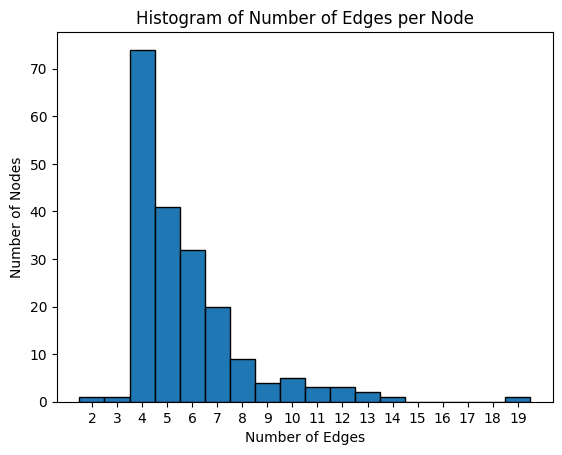

In [ ]:
# Create a list of the number of edges each node has
num_edges = [len(pruned_graph[node]) for node in pruned_graph.nodes]

# Calculate the minimum and maximum number of edges
min_edges = min(num_edges)
max_edges = max(num_edges)

# Create a range from the minimum to the maximum number of edges, with a step of 1
bins = np.arange(min_edges, max_edges + 2) - 0.5

# Create the histogram
plt.hist(num_edges, bins=bins, edgecolor='black')

# Set the title and labels
plt.title('Histogram of Number of Edges per Node')
plt.xlabel('Number of Edges')
plt.ylabel('Number of Nodes')

# Set the x-ticks to be the integers from the minimum to the maximum number of edges
plt.xticks(range(min_edges, max_edges + 1))

# Display the histogram
plt.show()

### Building the dataset.

I probably need around 20-30 different queries to evaluate the retrieval algorithms.